In [1]:
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 8

import datetime as dt
import os
import urllib.parse

import matplotlib.pyplot as plt
import scipy as sc

from data_oasis import utils

URL = urllib.parse.urlparse(os.environ['DATABASE_URL'])

In [2]:
conn = utils.get_connection(URL)

In [3]:
# Let's look at the racial disparity index across the entire state, broken down by race and year.
query = """
WITH 
    demographics AS (
        SELECT year, race, percentage
        FROM year_county_race
        WHERE county = 'All Combined' AND race <> 'All Combined'
        ),
    crime_total AS (
        SELECT year, sum(total) AS num_crimes
        FROM year_jurisdiction_offense
        WHERE status_type = 'booked'
        GROUP BY year
    ),
    crime_by_race_total AS (
        SELECT year, race, sum(total) AS num_crimes
        FROM year_jurisdiction_offense
        WHERE status_type = 'booked'
        GROUP BY year, race
    ),
    crime_demographics AS (
        SELECT ct.year, rt.race, (100.0 * rt.num_crimes) / ct.num_crimes as percent_crimes
        FROM crime_total as ct
        JOIN crime_by_race_total as rt
        ON ct.year = rt.year
    )

SELECT d.year, d.race, cd.percent_crimes / d.percentage as disparity_index
FROM demographics as d
JOIN crime_demographics as cd
ON d.year = cd.year
  AND d.race = cd.race
ORDER BY year, race;"""

with conn.cursor() as cur:
    cur.execute(query)
    cols = [c[0] for c in cur.description]
    result = cur.fetchall()
    df = pd.DataFrame(result, columns=cols)
    df['disparity_index'] = df['disparity_index'].astype(float)
    df['year'] = df['year'].apply(lambda x: dt.date(year=x, month=12, day=31))

[(0, 3.2),

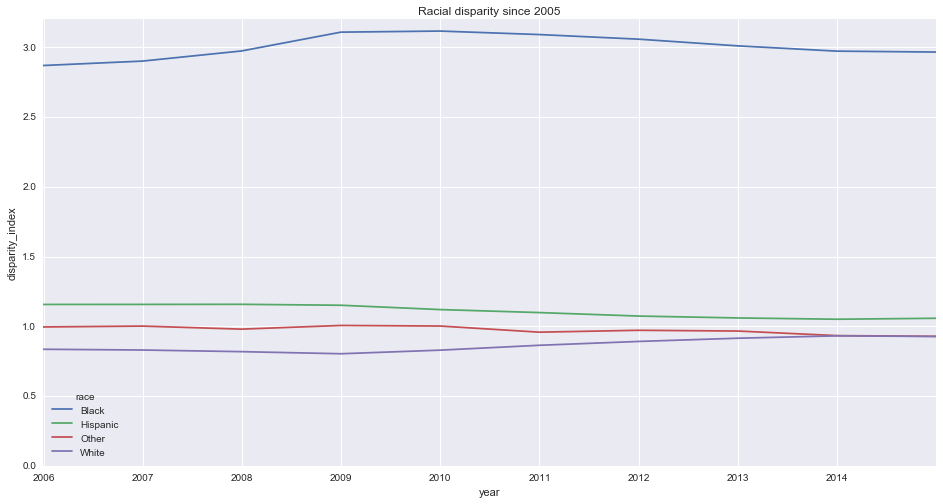

In [4]:
pivot = df.pivot('year', 'race', 'disparity_index')
ax = pivot.plot()
ax.set(xlabel='year', ylabel='disparity_index', ylim=(0, 3.2), title='Racial disparity since 2005')

In [3]:
# Let's look at the racial disparity index across the entire state, broken down by race, offense level, and year.
query = """WITH 
    demographics AS (
        SELECT year, race, percentage
        FROM year_county_race
        WHERE county = 'All Combined' AND race <> 'All Combined'
        ),
    crime_level_total AS (
        SELECT year, offense_level, sum(total) AS num_crimes
        FROM year_jurisdiction_offense
        GROUP BY year, offense_level
    ),
    crime_level_by_race_total AS (
        SELECT year, race, offense_level, sum(total) AS num_crimes
        FROM year_jurisdiction_offense
        GROUP BY year, race, offense_level
    ),
    crime_demographics AS (
        SELECT ct.year, rt.race, ct.offense_level, (100.0 * rt.num_crimes) / ct.num_crimes as percent_crimes
        FROM crime_level_total as ct
        JOIN crime_level_by_race_total as rt
          ON ct.year = rt.year
            AND ct.offense_level = rt.offense_level
    )

SELECT d.year, d.race, cd.offense_level, cd.percent_crimes / d.percentage as disparity_index
FROM demographics as d
JOIN crime_demographics as cd
  ON d.year = cd.year
  AND d.race = cd.race
ORDER BY year, race, offense_level;"""

with conn.cursor() as cur:
    cur.execute(query)
    cols = [c[0] for c in cur.description]
    result = cur.fetchall()
    df = pd.DataFrame(result, columns=cols)
    df['disparity_index'] = df['disparity_index'].astype(float)
    df['year'] = df['year'].apply(lambda x: dt.date(year=x, month=12, day=31))

In [13]:
by_race = df.groupby('race')
black = by_race.get_group('Black').pivot(index='year', columns='offense_level', values='disparity_index')
white = by_race.get_group('White').pivot(index='year', columns='offense_level', values='disparity_index')

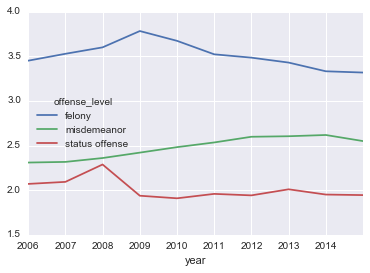

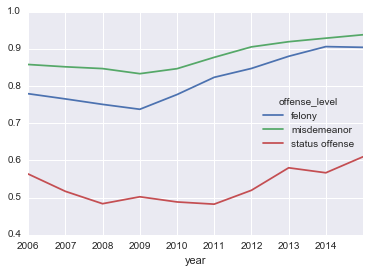

In [17]:
black.plot()
white.plot()

In [3]:
query = """-- I apologize profusely for the hideous length of this query...needed to deal with changes in BCS offense descriptions....
WITH 
    demographics_p1 AS (
        SELECT year, race, percentage
        FROM year_county_race
        WHERE county = 'All Combined' 
          AND race <> 'All Combined'
          AND year < 2013
        ),
    crime_bcs_total_p1 AS (
        SELECT y.year, y.bcs_summary_offense_code, o.summary_offense_type, y.num_crimes
        FROM (
            SELECT year, bcs_summary_offense_code, sum(total) as num_crimes
            FROM year_jurisdiction_offense
            where year < 2013
            GROUP by year, bcs_summary_offense_code) AS y
            JOIN (
                SELECT bcs_summary_offense_code, summary_offense_type
                FROM offense_summary_code
                where before_2013 IS TRUE) as o
            ON y.bcs_summary_offense_code = o.bcs_summary_offense_code
    ),
    crime_bcs_by_race_total_p1 AS (
        SELECT year, race, bcs_summary_offense_code, sum(total) AS num_crimes
        FROM year_jurisdiction_offense
        WHERE year < 2013
        GROUP BY year, race, bcs_summary_offense_code
    ),
    crime_demographics_p1 AS (
        SELECT ct.year, rt.race, ct.bcs_summary_offense_code, ct.summary_offense_type, (100.0 * rt.num_crimes) / ct.num_crimes as percent_crimes
        FROM crime_bcs_total_p1 as ct
        JOIN crime_bcs_by_race_total_p1 as rt
          ON ct.year = rt.year
            AND ct.bcs_summary_offense_code = rt.bcs_summary_offense_code
    ),
    demographics_p2 AS (
        SELECT year, race, percentage
        FROM year_county_race
        WHERE county = 'All Combined' 
          AND race <> 'All Combined'
          AND year >= 2013
        ),
    crime_bcs_total_p2 AS (
        SELECT y.year, y.bcs_summary_offense_code, o.summary_offense_type, y.num_crimes
        FROM (
            SELECT year, bcs_summary_offense_code, sum(total) as num_crimes
            FROM year_jurisdiction_offense
            where year >= 2013
            GROUP by year, bcs_summary_offense_code) AS y
            JOIN (
                SELECT bcs_summary_offense_code, summary_offense_type
                FROM offense_summary_code
                where before_2013 IS FALSE) as o
            ON y.bcs_summary_offense_code = o.bcs_summary_offense_code
    ),
    crime_bcs_by_race_total_p2 AS (
        SELECT year, race, bcs_summary_offense_code, sum(total) AS num_crimes
        FROM year_jurisdiction_offense
        WHERE year >= 2013
        GROUP BY year, race, bcs_summary_offense_code
    ),
    crime_demographics_p2 AS (
        SELECT ct.year, rt.race, ct.bcs_summary_offense_code, ct.summary_offense_type, (100.0 * rt.num_crimes) / ct.num_crimes as percent_crimes
        FROM crime_bcs_total_p2 as ct
        JOIN crime_bcs_by_race_total_p2 as rt
          ON ct.year = rt.year
            AND ct.bcs_summary_offense_code = rt.bcs_summary_offense_code
    ),
    demographics AS (
    	select * from demographics_p1 UNION select * from demographics_p2
    ),
    crime_demographics AS (
    	select * from crime_demographics_p1 UNION select * from crime_demographics_p2
    )

SELECT d.year, d.race, cd.bcs_summary_offense_code, cd.summary_offense_type, cd.percent_crimes / d.percentage as disparity_index
FROM demographics AS d
JOIN crime_demographics AS cd
  ON d.year = cd.year
  AND d.race = cd.race
ORDER BY year, bcs_summary_offense_code, race;
"""

with conn.cursor() as cur:
    cur.execute(query)
    cols = [c[0] for c in cur.description]
    result = cur.fetchall()
    df = pd.DataFrame(result, columns=cols)
    df['disparity_index'] = df['disparity_index'].astype(float)
    df['year'] = df['year'].apply(lambda x: dt.date(year=x, month=12, day=31))


In [34]:
df['wat'] = list(zip(df['bcs_summary_offense_code'], df['summary_offense_type']))
by_race = df.groupby('race')
race = by_race.get_group('White')
%matplotlib notebook
disparity_by_year = race.pivot(index='year', columns='wat', values='disparity_index')
idx = [x.year for x in disparity_by_year.index]
year = disparity_by_year.index
disparity_by_year.index = idx

In [45]:
def crude_lingress(df):
    result = {}
    
    for col in df.columns:
        slope, _, _, p, _ = sc.stats.linregress(df.index.values, df[col].values)
        result[col] = (slope, p,)
    return result

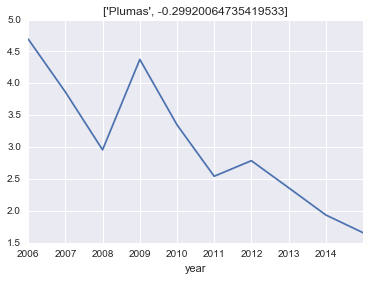

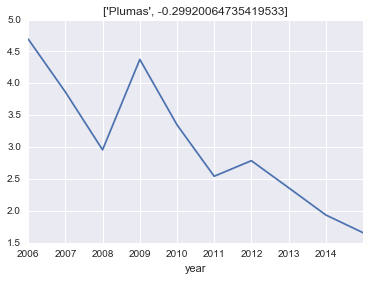

In [41]:
%matplotlib inline
from IPython import display
make_ax = True
disparity_by_year.index = year
for col, val in col_val.items():
    plt.gca().cla()
    disparity_by_year[col].plot(title=[col, val])
    display.clear_output(wait=True)
    display.display(plt.gcf()) 
    time.sleep(2) 


In [84]:
# Now, let's look at racial disparity by county
query = """WITH 
    demographics AS (
        SELECT year, race, county, population, percentage
        FROM year_county_race
        WHERE county <> 'All Combined' AND race <> 'All Combined'
        ),
    crime_total AS (
        SELECT year, county, sum(total) AS num_crimes
        FROM year_jurisdiction_offense
        where status_type = 'booked'
        GROUP BY year, county
    ),
    crime_by_race_total AS (
        SELECT year, county, race, sum(total) AS num_crimes
        FROM year_jurisdiction_offense
        where status_type = 'booked'
        GROUP BY year, county, race
    ),
    crime_demographics AS (
        SELECT ct.year, ct.county, rt.race, (100.0 * rt.num_crimes) / ct.num_crimes as percent_crimes, rt.num_crimes, ct.num_crimes as num_crimes_in_cat
        FROM crime_total as ct
        JOIN crime_by_race_total as rt
        ON ct.year = rt.year
          AND ct.county = rt.county
    )

SELECT d.year, d.county, d.race, d.population, d.percentage as percent_total_pop, cd.percent_crimes / (0.0001 + d.percentage) as disparity_index, cd.num_crimes, cd.num_crimes_in_cat
FROM demographics as d
JOIN crime_demographics as cd
ON d.year = cd.year
  AND d.race = cd.race
  AND d.county = cd.county
ORDER BY year, county, race;"""

with conn.cursor() as cur:
    cur.execute(query)
    cols = [c[0] for c in cur.description]
    result = cur.fetchall()
    df = pd.DataFrame(result, columns=cols)
    df['disparity_index'] = df['disparity_index'].astype(float)
    df['year'] = df['year'].apply(lambda x: dt.date(year=x, month=12, day=31))
    df['x'] = df['year'].apply(lambda x: x.year)

In [85]:
by_race = df.groupby('race')
race = by_race.get_group('White')
disparity_by_year = race.pivot(index='year', columns='county', values='disparity_index')
idx = [x.year for x in disparity_by_year.index]
year = disparity_by_year.index
disparity_by_year.index = idx